In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [ ]:
batch_size = 1000
epochs = 200
sample_size = 64
nz = 28*28
k = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# from torchvision.transforms.func/tional import to_pil_image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()


In [ ]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

Feature batch shape: torch.Size([1000, 1, 28, 28])
Labels batch shape: torch.Size([1000])
tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000

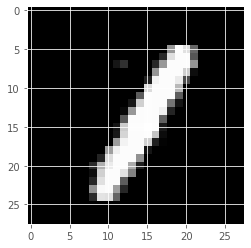

Label: 1


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(img)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
print(len(train_loader))

60


In [ ]:
class Generator(nn.Module):
  def __init__(self,nz):
    super(Generator,self).__init__()
    self.nz=nz
    self.main = nn.Sequential(
        nn.Linear(self.nz,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,784),
        nn.Sigmoid(),
        
    )

  def forward(self,x):
    return self.main(x).view(-1,1,28,28)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.n_input = 784
    self.main = nn.Sequential(
        nn.Linear(self.n_input,2*28*28),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(2*28*28, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    x = x.view(-1,784)
    return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
optim_g = optim.Adam(generator.parameters(), lr=0.00005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.000003)
criterion = nn.BCELoss()
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] #

In [ ]:
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size,nz):
  return torch.randn(sample_size,nz).to(device)

def save_generator_image(image,path):
  save_image(image,path)

In [ ]:
def train_discriminator(optimizer, data_real,data_fake):
  b_size = data_real.size(0)
  real_label = label_real(b_size)
  fake_label = label_fake(b_size)
  optimizer.zero_grad()
  output_real = discriminator(data_real)
  output_fake = discriminator(data_fake)
  loss_real = criterion(real_label,output_real)
  loss_fake = criterion(fake_label,output_fake)
  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real + loss_fake

def train_generator(optimizer,data_fake):
  b_size = data_fake.size(0)
  real_label = label_real(b_size)
  optimizer.zero_grad()
  output = discriminator(data_fake)
  loss = criterion(real_label,output)
  loss.backward()
  optimizer.step()
  return loss

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1568, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1568, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

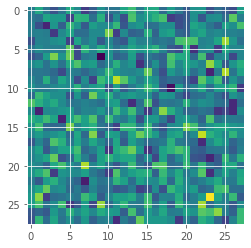

In [ ]:
noise = create_noise(sample_size,28*28)
plt.imshow(noise[0].view(28,28))
generator.train()
discriminator.train()

In [ ]:
from IPython.display import clear_output
def plot_all_losses(d_real_loss, d_fake_loss, g_loss_run):
    plt.plot(d_real_loss, label = "D-real-loss")
    plt.plot(d_fake_loss, label = "D-fake-loss")
    plt.plot(g_loss_run, label = "G-loss")
    plt.legend()
    plt.show()

def show_gen_sample(z,G):

    samples = G(z[0]).detach()
    samples = samples.view([28,28])
    sample = samples.numpy()
    plt.imshow(sample, cmap = "gray")
    plt.show()


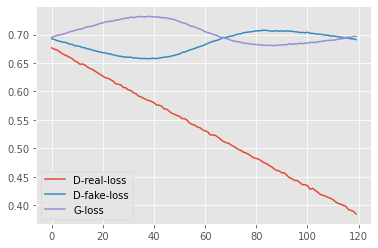

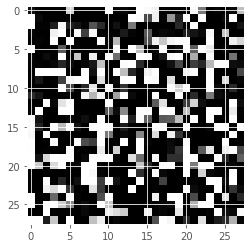

100%|██████████| 60/60 [01:32<00:00,  1.54s/it]


In [ ]:
g_loss_run=[]
d_real_loss = []
d_fake_loss = []

for epoch in range(2):
  for data in tqdm(train_loader):
    print(epoch + 1)
    x, _ = data
    # print(x.data[0])
    # plt.show(x.data[0])
    siz = x.size(0)
    x = x.view(x.size(0),-1)
    one_labels = label_real(siz)
    zeroes_labels = label_fake(siz)
    z = create_noise(siz,nz)
    g_sample = generator(z)
    # print(g_sample)
    d_fake = discriminator(g_sample)
    d_real = discriminator(x)
    # print(d_fake)
    Dfake_loss = criterion(d_fake,zeroes_labels)
    Dreal_loss = criterion(d_real,one_labels)
    d_loss = Dfake_loss + Dreal_loss
    optim_d.zero_grad()
    d_loss.backward()
    optim_d.step()
    
    z = create_noise(siz,nz)
    g_sample = generator(z)
    d_fake = discriminator(g_sample)
    D_loss = criterion(d_fake,one_labels)
    optim_g.zero_grad()
    D_loss.backward()
    optim_g.step()
    # g_loss = D_loss

    g_loss_run.append(D_loss.detach().numpy())
    d_real_loss.append(Dreal_loss.detach().numpy())
    d_fake_loss.append(Dfake_loss.detach().numpy())

    clear_output(wait = True)
    plot_all_losses(d_real_loss, d_fake_loss, g_loss_run)
    show_gen_sample(z,generator)



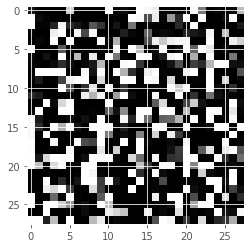

In [ ]:
show_gen_sample(create_noise(1,28*28),generat)


In [ ]:
# for epoch in range(epochs):
#   loss_g = 0.0
#   loss_d = 0.0
#   for bi, data in tqdm(enumerate(train_loader),total=int(len(train_data)/train_loader.batch_size)):
#     image, _ = data
#     image = image.to(device)
#     b_size = len(image)
#     for step in range(k):
#       data_fake = generator(create_noise(b_size,nz)).detach()
#       data_real = image
#       loss_d += train_discriminator(optim_d,data_real,data_fake)

#     data_fake = generator(create_noise(b_size,nz))
#     loss_g += train_generator(optim_g,data_fake)

#     generated_img = generator(noise).cpu().detach()
#     # make the images as grid
#     generated_img = make_grid(generated_img)
#     # save the generated torch tensor models to disk
#     save_generator_image(generated_img, f"./outputs/gen_img{epoch}.png")
#     images.append(generated_img)
#     epoch_loss_g = loss_g / bi # total generator loss for the epoch
#     epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
#     losses_g.append(epoch_loss_g)
#     losses_d.append(epoch_loss_d)
    
#     print(f"Epoch {epoch} of {epochs}")
#     print(f"Generator loss: {epoch_loss_g}, Discriminator loss: {epoch_loss_d}")

In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('./outputs/generator_images.gif', imgs)

In [ ]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss.png')